# Book translation

![](img/dcts.jpg)

Mar, 2024
> Machine Translation (MT)

## Background
A few years ago, I wrote a book in Spanish about my personal experience walking the Camino de Santiago. At the time, I considered translating it into English to reach more readers on Amazon, but I discarded the idea because of the effort and costs involved.

However, with the advancement of Artificial Intelligence during these last few years, I thought it would be interesting to experiment with some model to automatically translate the book for me. Perhaps it would turn out so well that it wouldn't need further manual adjustments by humans.

The historical evolution of Machine Translation has been the following one:

- 1950 - 2000: **Rule based** linguistic approach.
- 2000 - 2010: **Statistical approach**. Access to many bilingual texts. Instead of building rules, statistical models were considered.
- 2010 - 202x: **Neural Machine Translation (NMT)**. Advanced Deep Learning models, more data available to train models, more computing power.

And in this latest phase, it is worth noting the emergence of **Generative Artificial Intelligence**, with large language models (such as OpenAI's GPT: a **LLM** based on complex Deep Learning architectures) trained for text generation, _which can also be used for translating_.

So, I decided to make a foray into this world to explore the possibilities before carrying out the full translation of my book.

## Comparing models

### The data
To compare translation results across different models, I would use a metric, for which first of all I needed a dataset with sentences in Spanish and their correct translation into English. For this, I relied on [Tatoeba](https://tatoeba.org/), a collaborative website dedicated to collecting sentences and their translations into multiple languages.

I downloaded a file containing over a quarter of a million translated sentences. I sorted the entries by length and kept the top thousand longest Spanish sentences (and their corresponding translations). I thought that for translating a book like mine, when comparing models, it would be best to make them work on longer sentences rather than shorter ones.

In [68]:
import time

import matplotlib.pyplot as plt
import my_functions as my
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import clear_output

# Google Translator
from deep_translator import GoogleTranslator

# Hugging Face
from transformers import pipeline
from evaluate import load

# OpenAI
from openai import OpenAI
import tiktoken

# # https://tatoeba.org/es/downloads, es --> en
# tatoeba = pd.read_csv("data/tatoeba-es-en-2024-03-13.tsv",
#                       sep="\t",
#                       header=None,
#                       usecols=[1, 3],
#                       names=["es", "en"])
#
# # Sort by length of the sentence
# tatoeba = tatoeba.sort_values(by="es",
#                               key=lambda x: x.str.len(),
#                               ascending=False)
#
# # Subset n longest sentences
# n = 1000
# tatoeba_n = tatoeba.iloc[:n, :].reset_index(drop=True)
#
# # Save as csv file
# tatoeba_n.to_csv("data/tatoeba_n.csv", index=False)

tatoeba_n = pd.read_csv("data/tatoeba_n.csv")

### Translators
In my comparison, I was clear that I wanted to include **Google Translate** and **OpenAI's GPT** text generation tool. Since both are proprietary models, I thought it would be interesting to also have a free open-source model that I could run locally on my computer.

A quick search on [Hugging Face](https://huggingface.co/Helsinki-NLP/opus-mt-es-en) convinced me to use the **Helsinki-NLP/opus-mt-es-en** model, an open-source model ready to translate text from Spanish to English. It is a project led by the University of Helsinki, co-funded by the EU, in which they have fine-tuned for language couples the open pre-trained model Mariam-NMT on a corpus of translated texts from the web called [OPUS](https://opus.nlpl.eu/).

For this project, I instantiated each of these models as follows:

- For the Helsinki-NLP model I used a Hugging Face pipeline. This has the model downloaded locally in my computer before running it.
- For Google Translate I used a library called [deep_translator](https://pypi.org/project/deep-translator/) as a wrapper to the Google API (no costs involved).
- For GPT, I utilized the [OpenAI API](https://openai.com/pricing), using my key for access and billing. As model I selected the _gpt-3.5-turbo_, which is not as advanced as GPT-4 but may be enough for the purpose (and cheaper!).

In [15]:
# Instanciate Helsinki model
helsinkitranslator = pipeline(task="translation", model="Helsinki-NLP/opus-mt-es-en")

# Instanciate Google Translator
googletranslator = GoogleTranslator(source="es", target="en")

# Instanciate OpenAI-GPT
api_key = "xxx"
gptranslator = OpenAI(api_key=api_key)


# Function to translate with Helsinki model
def translate_helsinki(client, text):
    trans_hel = client(text)[0]["translation_text"]
    return trans_hel


# Function to translate with Google model
def translate_google(client, text):
    max_attempts = 5
    retry_gap = 3.0  # Initial gap between retries in seconds
    for attempt in range(max_attempts):
        try:
            trans_goo = client.translate(text)
            break  # Break inner loop on success
        except Exception as e:
            print(f"Request failed on attempt {attempt + 1}. Error: {str(e)}")
            if attempt < max_attempts - 1:
                retry_gap *= 1.5  # Increase the retry gap exponentially
                time.sleep(retry_gap)
    return trans_goo


# Function to translate with GPT model
def translate_gpt(client, text):
    # Parameters
    gpt_model = "gpt-3.5-turbo"
    model_parameters = {"model": gpt_model, "temperature": 0.0}
    system_prompt = f"""You are a translation tool.
    You receive a string written in Spanish, and solely return the same string in English without losing any of the original formatting.
    Your translations should be accurate, aiming not to deviate from de original structure, content, writing style and tone."""

    max_attempts = 5
    retry_gap = 3.0  # Initial gap between retries in seconds
    for attempt in range(max_attempts):
        try:
            messages = [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": text},
            ]
            completion = client.chat.completions.create(
                **model_parameters, messages=messages
            )
            trans_gpt = completion.choices[0].message.content
            tokens_in = completion.usage.prompt_tokens
            tokens_out = completion.usage.completion_tokens
            break  # Break inner loop on success
        except Exception as e:
            print(f"Request failed on attempt {attempt + 1}. Error: {str(e)}")
            if attempt < max_attempts - 1:
                retry_gap *= 1.5  # Increase the retry gap exponentially
                time.sleep(retry_gap)

    return trans_gpt, tokens_in, tokens_out


# Function to calculate cost for "gpt-3.5-turbo"
def cost_gpt(tokens_in, tokens_out):
    price_in = 1.50  # $ /1M tokens
    price_out = 2.00  # $ /1M tokens
    return (tokens_in * price_in / 1000000) + (tokens_out * price_out / 1000000)

### SacreBLEU metric
As comparison metric I used SacreBLEU from the [Hugging Face](https://huggingface.co/spaces/evaluate-metric/sacrebleu) evaluation library.

I had the three models translate successively the 1000 sentences extracted from the Tatoeba database. I compared each translation with the reference translation in Tatoeba, thus obtaining 1000 SacreBLEU scores for each of the 3 models.

In [3]:
# Translate
goo_lst = []
hel_lst = []
gpt_lst = []
tokens_in_consumed = 0
tokens_out_consumed = 0
counter = 0
n_chunks = len(tatoeba_n)
for text in tatoeba_n["es"]:

    # Google Translator
    goo_lst.append(translate_google(googletranslator, text))

    # Helsinki-NLP
    hel_lst.append(translate_helsinki(helsinkitranslator, text))

    # OpenAI-GPT
    translation, tokens_in, tokens_out = translate_gpt(gptranslator, text)
    tokens_in_consumed += tokens_in
    tokens_out_consumed += tokens_out
    gpt_lst.append(translation)

    counter += 1
    clear_output()
    print(f"...\nCompleted: {counter} / {n_chunks}")

print(f"\nCost GPT: {cost_gpt(tokens_in_consumed, tokens_out_consumed):.2f} $")

...
Completed: 1000 / 1000

Cost GPT: 0.30 $


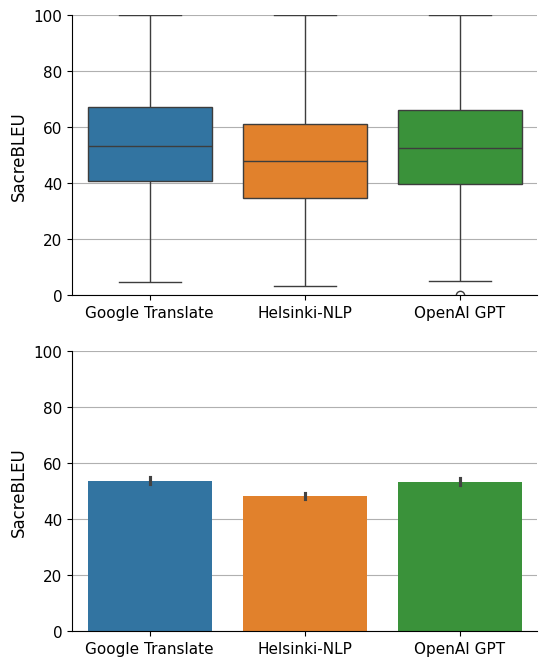

In [17]:
# Instanciate evaluation metric
sacrebleu = load("sacrebleu", trust_remote_code=True)

# Evaluate
goo_scores = []
hel_scores = []
gpt_scores = []
for text, goo, hel, gpt in zip(tatoeba_n["en"], goo_lst, hel_lst, gpt_lst):
    references = [[text]]

    # Google Translator
    predictions = [goo]
    goo_scores.append(
        sacrebleu.compute(predictions=predictions, references=references)["score"]
    )

    # Helsinki-NLP
    predictions = [hel]
    hel_scores.append(
        sacrebleu.compute(predictions=predictions, references=references)["score"]
    )

    # OpenAI-GPT
    predictions = [gpt]
    gpt_scores.append(
        sacrebleu.compute(predictions=predictions, references=references)["score"]
    )

# Mean values
goo_scores_mean = np.mean(goo_scores)
hel_scores_mean = np.mean(hel_scores)
gpt_scores_mean = np.mean(gpt_scores)

# Convert to df to plot
scores = pd.DataFrame(
    [goo_scores, hel_scores, gpt_scores],
    index=["Google Translate", "Helsinki-NLP", "OpenAI GPT"],
).transpose()

# Get new column with length
scores["len_es"] = tatoeba_n["es"].apply(len)

# Long format to plot in Seaborn
scores = scores.melt(id_vars=["len_es"]).rename(
    columns={"variable": "model", "value": "score"}
)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

sns.boxplot(x="model", y="score", data=scores, ax=ax[0], hue="model")

sns.barplot(x="model", y="score", data=scores, ax=ax[1], hue="model")

for i in range(2):
    ax[i].grid(axis="y")
    ax[i].set_axisbelow(True)
    ax[i].tick_params(axis="y", which="major", labelsize=11)
    ax[i].tick_params(axis="x", which="major", labelsize=11)
    ax[i].set_title("", size=13)
    ax[i].set_xlabel("", size=12)
    ax[i].set_ylabel("SacreBLEU", size=12)
    ax[i].set_ylim(0, 100)

sns.despine()

plt.show()

It doesn't seem like there's much difference between the three models, although Google and GPT seem to achieve slightly better results than Helsinki in terms of SacreBLEU averages and medians. How much better? The confidence intervals are not too distinct in this last bar chart. I decided to calculate the distribution of their means to see it more clearly.

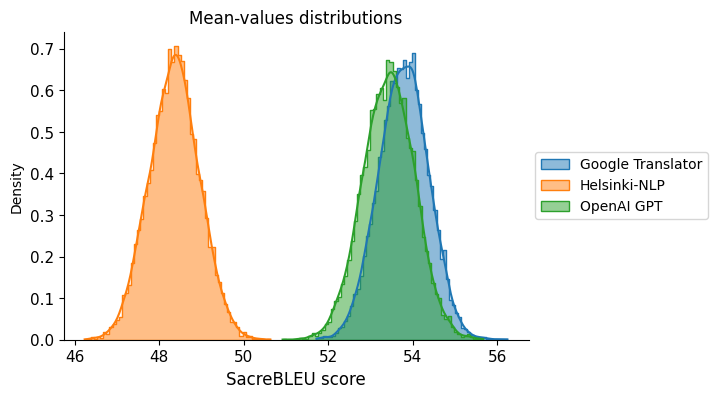

In [18]:
# Establish random numbers' seed for reproducibility
np.random.seed(111)

# Draw bootstrap replicates
bs_reps_goo_scores = my.draw_bs_reps(np.array(goo_scores), np.mean, size=10000)
bs_reps_hel_scores = my.draw_bs_reps(np.array(hel_scores), np.mean, size=10000)
bs_reps_gpt_scores = my.draw_bs_reps(np.array(gpt_scores), np.mean, size=10000)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(
    bs_reps_goo_scores,
    ax=ax,
    kde=True,
    stat="density",
    element="step",
    label="Google Translator",
)
sns.histplot(
    bs_reps_hel_scores,
    ax=ax,
    kde=True,
    stat="density",
    element="step",
    label="Helsinki-NLP",
)
sns.histplot(
    bs_reps_gpt_scores,
    ax=ax,
    kde=True,
    stat="density",
    element="step",
    label="OpenAI GPT",
)

ax.set_title("Mean-values distributions", size=12)
ax.tick_params(axis="x", labelsize=11, rotation=0)
ax.tick_params(axis="y", labelsize=11)
ax.set_xlabel("SacreBLEU score", size=12)
ax.legend(bbox_to_anchor=(1.0, 0.5), loc="center left", fontsize=10)
sns.despine()

plt.show()

Here it is clear that the difference between Google Translator and OpenAI GPT compared to Helsinki is significant in the tests conducted on the sample of 1000 long sentences.

## Translating the book
I carried out the translation of my book on these three systems. The quality of the translation should be checked later by myself (or by a professional translator or native speaker), but for now, I also wanted to see the differences in the time required and the cost.

The book is titled [_De Camino Tu Santiago_](https://www.amazon.es/Camino-Tu-Santiago-viaje-pie/dp/1082388130) and consists of approximately 65,000 words in Spanish.

To begin with, I loaded the book from the text file where I stored it and split it into chunks separated by line breaks to proceed with its translation paragraph by paragraph.

In [19]:
# Open book file
with open("data/dcts.txt", "r") as file:
    file_text = file.read()

# Split file
split_string = "\n"
split_text = file_text.split(split_string)

# Number of chunks
n_chunks = len(split_text)
print(f"Number of paragraphs --> {n_chunks}")

Number of paragraphs --> 1290


### OpenAI GPT
A book of 65,000 words translates to approximately the following number of tokens for GPT.

In [20]:
# Load the encoder for the OpenAI text-embedding-ada-002 model
enc = tiktoken.encoding_for_model("gpt-3.5-turbo")

# Encode each text in documents and calculate the total tokens
book_tokens = len(enc.encode(file_text))
print(f"Book input tokens -> {book_tokens}")

Book input tokens -> 105909


So at least twice as many tokens will be consumed since the result of the translation also needs to be taken into account.

Let's proceed with the translation using OpenAI's GPT:

In [21]:
st = time.time()
trans = ""
doc = ""
counter = 0
tokens_in_consumed = 0
tokens_out_consumed = 0
for text in split_text:
    if not text.strip():
        trans = ""
    else:
        trans, tokens_in, tokens_out = translate_gpt(gptranslator, text)
        tokens_in_consumed += tokens_in
        tokens_out_consumed += tokens_out

    counter += 1
    clear_output()
    print(f"...\nCompleted: {counter} / {n_chunks}")
    doc += trans + "\n"

# Get elapsed time
et = time.time()
elapsed_time_gpt = et - st

# Get tokens and cost
total_tokens = tokens_in_consumed + tokens_out_consumed
cost_gpt = cost_gpt(tokens_in_consumed, tokens_out_consumed)

print(f"\nExecution time: {elapsed_time_gpt:.0f} s")
print(f"\nTotal tokens: {total_tokens}")
print(f"\nCost GPT: {cost_gpt:.2f} $")

...
Completed: 1290 / 1290

Execution time: 2008 s

Total tokens: 262180

Cost GPT: 0.43 $


I save the translation in a new file named _dcts_en_gpt.txt_.

In [23]:
with open("data/dcts_en_gpt.txt", "w", encoding="utf-8") as file:
    file.write(doc)

### Google Translate
Let's proceed with the translation using Google Translate:

In [24]:
st = time.time()
trans = ""
doc = ""
counter = 0
for text in split_text:
    if not text.strip():
        trans = ""
    else:
        trans = translate_google(googletranslator, text)

    counter += 1
    clear_output()
    print(f"...\nCompleted: {counter} / {n_chunks}")
    doc += trans + "\n"

# Get elapsed time
et = time.time()
elapsed_time_goo = et - st

print(f"\nExecution time: {elapsed_time_goo:.0f} s")

...
Completed: 1290 / 1290

Execution time: 2650 s


I save the translation in a new file named _dcts_en_goo.txt_.

In [25]:
with open("data/dcts_en_goo.txt", "w", encoding="utf-8") as file:
    file.write(doc)

### Helsinki-NLP
Let's proceed with the translation using the open-source model by Helsinki-NLP:

In [26]:
st = time.time()
trans = ""
doc = ""
counter = 0
for text in split_text:
    if not text.strip():
        trans = ""
    else:
        trans = translate_helsinki(helsinkitranslator, text)

    counter += 1
    clear_output()
    print(f"...\nCompleted: {counter} / {n_chunks}")
    doc += trans + "\n"

# Get elapsed time
et = time.time()
elapsed_time_hel = et - st

print(f"\nExecution time: {elapsed_time_hel:.0f} s")

...
Completed: 1290 / 1290

Execution time: 3747 s


I save the translation in a new file named _dcts_en_hel.txt_.

In [27]:
with open("data/dcts_en_hel.txt", "w", encoding="utf-8") as file:
    file.write(doc)

## Conclusions
I gather the results into a table to compare them.

In [71]:
pd.DataFrame(
    {
        "Score": [goo_scores_mean, hel_scores_mean, gpt_scores_mean],
        "Time": [
            time.strftime("%H:%M:%S", time.gmtime(elapsed_time_goo)),
            time.strftime("%H:%M:%S", time.gmtime(elapsed_time_hel)),
            time.strftime("%H:%M:%S", time.gmtime(elapsed_time_gpt)),
        ],
        "Cost ($)": [0, 0, cost_gpt],
    },
    index=["Google Translate", "Helsinki-NLP", "OpenAI GPT"],
).round({"Score": 1, "Cost ($)": 2}).transpose()

,Google Translate,Helsinki-NLP,OpenAI GPT
Score,53.8,48.4,53.4
Time,00:44:10,01:02:27,00:33:27
Cost ($),0.0,0.0,0.43


Regarding the quality of the translations, I would need to look into it more closely, although a quick glance indicates that both Google and GPT indeed seem to perform slightly better than Helsinki. However, the files containing these translations are available on GitHub for anyone to judge.

I was surprised that GPT was the fastest in translating the book, in just over half an hour. And that it took Helsinki an hour, running it on my own computer. However, I suspect that these times will vary depending on the time of the day the OpenAI and Google API services are queried, as well as the processing power of each PC for the case of open-source models run locally.

As for the cost, Google and Helsinki are free, while the translation by OpenAI using _GPT 3.5 Turbo_ cost me 0.43 dollars, 0.39 euros at today's exchange rate, which can be considered reasonable.